In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [ ]:
DataDir = '/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b'
Categories = ['aluminium_foil', 'brown_bread', 'corduroy', 'cork', 'cotton', 'cracker', 'lettuce_leaf', 'linen', 'white_bread', 'wood','wool']
Samples = ['sample_a','sample_b','sample_c', 'sample_d']
images = []
y = np.array([])

In [ ]:
for category in Categories:
  for Sample in Samples:
    path = os.path.join(DataDir,category)
    path = os.path.join(path,Sample)
    class_num = Categories.index(category)
    print(path)
    for imgname in os.listdir(path):
        img = cv.imread(os.path.join(path,imgname))
        img = cv.resize(img, (300, 300))
        images.append(img)
        y=np.append(y,[class_num])
      
        
  
x = np.array(images)
print(x.shape)

/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/aluminium_foil/sample_a
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/aluminium_foil/sample_b
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/aluminium_foil/sample_c
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/aluminium_foil/sample_d
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/brown_bread/sample_a
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/brown_bread/sample_b
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/brown_bread/sample_c
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/brown_bread/sample_d
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/corduroy/sample_a
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/corduroy/sample_b
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/corduroy/sample_c
/content/drive/MyDrive/PS 1/Datasets/KTH-TIPS-2B/KTH-TIPS2-b/corduroy/sample_d
/content/drive/M

In [ ]:
y = np.reshape(y,(-1,1))
print(y.shape)
print(y)

(4752, 1)
[[ 0.]
 [ 0.]
 [ 0.]
 ...
 [10.]
 [10.]
 [10.]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [ ]:
X_train = X_train /255
X_test = X_test/255
X_val =X_val/255

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(712, 300, 300, 3)
(238, 300, 300, 3)
(238, 300, 300, 3)


In [ ]:

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(712, 1)
(238, 1)
(238, 1)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
print(train_ds)
print(train_ds)
print(val_ds)

<TensorSliceDataset shapes: ((300, 300, 3), (1,)), types: (tf.uint8, tf.float64)>
<TensorSliceDataset shapes: ((300, 300, 3), (1,)), types: (tf.uint8, tf.float64)>
<TensorSliceDataset shapes: ((300, 300, 3), (1,)), types: (tf.uint8, tf.float64)>


In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()

print('Train size:', train_ds_size)
print('Test size:', test_ds_size)
print('Val size:', val_ds_size)

Train size: 712
Test size: 238
Val size: 238


In [ ]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(227,227))
    
    return image,label

In [ ]:
train_ds = (train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=30,drop_remainder=True)
         )

test_ds = (test_ds
           .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=30,drop_remainder=True)
         )

val_ds = (val_ds
          .map(process_image)
          .shuffle(buffer_size=val_ds_size)
          .batch(batch_size=30,drop_remainder=True)
         )

In [ ]:
from keras import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, Activation, Input, concatenate, Lambda, ZeroPadding2D, MaxPooling2D, Layer, Flatten
from keras.optimizers import SGD
from keras.backend import l2_normalize, expand_dims, variable, constant
import cv2, numpy as np
##from netvladlayer import NetVLAD
import keras
from keras import regularizers
from keras.layers import *
from keras.models import Model
import keras.backend as K

In [ ]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=X_train[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(120, activation='tanh'), #C5
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(11, activation='softmax') #Output layer
])


In [ ]:
lenet_5_model.compile(optimizer=tf.optimizers.SGD(lr=0.00003), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history= lenet_5_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

In [ ]:
history= lenet_5_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
23/23 [==============================] - 3s 85ms/step - loss: 2.6261 - accuracy: 0.0934 - val_loss: 2.4881 - val_accuracy: 0.1807
Epoch 2/50
23/23 [==============================] - 1s 48ms/step - loss: 2.1976 - accuracy: 0.2344 - val_loss: 1.9910 - val_accuracy: 0.3866
Epoch 3/50
23/23 [==============================] - 1s 49ms/step - loss: 1.9955 - accuracy: 0.3128 - val_loss: 1.8580 - val_accuracy: 0.3235
Epoch 4/50
23/23 [==============================] - 1s 49ms/step - loss: 1.8235 - accuracy: 0.3376 - val_loss: 1.8826 - val_accuracy: 0.2269
Epoch 5/50
23/23 [==============================] - 1s 49ms/step - loss: 1.7121 - accuracy: 0.3681 - val_loss: 2.1593 - val_accuracy: 0.2437
Epoch 6/50
23/23 [==============================] - 1s 49ms/step - loss: 1.6361 - accuracy: 0.4477 - val_loss: 2.0011 - val_accuracy: 0.2269
Epoch 7/50
23/23 [==============================] - 1s 49ms/step - loss: 1.6762 - accuracy: 0.3557 - val_loss: 1.7649 - val_accuracy: 0.2815
Epoch 8/50
23

In [ ]:
history= lenet_5_model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
23/23 [==============================] - 3s 85ms/step - loss: 2.4418 - accuracy: 0.0756 - val_loss: 2.4116 - val_accuracy: 0.1176
Epoch 2/500
23/23 [==============================] - 1s 48ms/step - loss: 2.4071 - accuracy: 0.1257 - val_loss: 2.3865 - val_accuracy: 0.1092
Epoch 3/500
23/23 [==============================] - 1s 49ms/step - loss: 2.3782 - accuracy: 0.1550 - val_loss: 2.3692 - val_accuracy: 0.1471
Epoch 4/500
23/23 [==============================] - 1s 49ms/step - loss: 2.3594 - accuracy: 0.1806 - val_loss: 2.3543 - val_accuracy: 0.1176
Epoch 5/500
23/23 [==============================] - 1s 48ms/step - loss: 2.3420 - accuracy: 0.1682 - val_loss: 2.3421 - val_accuracy: 0.0924
Epoch 6/500
23/23 [==============================] - 1s 49ms/step - loss: 2.3443 - accuracy: 0.1203 - val_loss: 2.3293 - val_accuracy: 0.1050
Epoch 7/500
23/23 [==============================] - 1s 48ms/step - loss: 2.3160 - accuracy: 0.1428 - val_loss: 2.3177 - val_accuracy: 0.1008
Epoch 

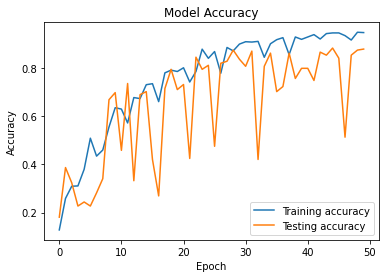

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
%matplotlib inline

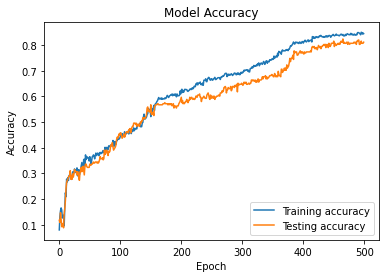

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
%matplotlib inline

In [ ]:
class NetVlad(Layer):
    def __init__(self, n_centers, output_dim, **kwargs):
        self.n_centers = n_centers
        self.output_dim = output_dim
        super(NetVlad, self).__init__(**kwargs)

    def build(self, input_shape):
        try:
            assert len(input_shape) == 3
        except:
            raise ValueError('Input should have shape (batch_size, time_steps, dims)')
            
        self.centers = self.add_weight(name='centers',
                                       shape=(self.n_centers, input_shape[-1]),
                                       initializer='uniform', 
                                       trainable=True
                                      )
        self.weight = self.add_weight(name='weight',
                                       shape=(input_shape[-1], self.n_centers),
                                       initializer='glorot_uniform', 
                                       trainable=True
                                      )
        self.bias = self.add_weight(name='bias',
                                    shape=(self.n_centers,),
                                    initializer='zeros', 
                                    trainable=True
                                   )
        self.reduc_dim = self.add_weight(name='reduc_dim',
                                         shape=(input_shape[-1]*self.n_centers, self.output_dim),
                                         initializer='zeros', 
                                         trainable=True
                                        )
        super(NetVlad, self).build(input_shape)

    def call(self, x):
        # X is shape (bsize, time_steps, input_size)
        # Get weights: shape=(bsize, time_steps, n_centers)
        centers_weight = K.softmax(K.dot(x, self.weight) + self.bias)
        assert centers_weight.shape[2] == self.n_centers
        assert centers_weight.shape[1] == x.shape[1]
        
        # Agg by cluster: shape=(bsize, n_centers, input_size)
        x_agg_clusters = K.batch_dot(centers_weight, x, axes=1)
        
        # Sum weights ad repeates in time dimension shape=(bsize, input_size, n_centers)
        sum_weights = K.sum(centers_weight, axis=1)        
        repeat_weights = K.repeat(sum_weights, x.shape[-1])
        # transpose to dim (bsize, n_centers, input_size)
        repeat_weights = K.permute_dimensions(repeat_weights,
                                              pattern=(0,2,1))
        # get full representation and flatten
        full_rep = x_agg_clusters - repeat_weights * self.centers
        full_rep = K.l2_normalize(full_rep, axis=-1)
        full_rep = K.reshape(full_rep, shape=(-1, self.n_centers * x.shape[2].value))
        full_rep = K.l2_normalize(full_rep, axis=-1)
        # Reduce dimension
        result = K.dot(full_rep, self.reduc_dim)
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.output_dim)   

def netvlad_model():
    in_ = Input(shape=(4,2048), name='img')
    
    rep = NetVlad(n_centers=32, output_dim=2048)(in_)  
    rep = Dropout(0.2)(rep)
    
    # context gating
    gate = Dense(2048, activation='sigmoid')(rep)
    rep = Multiply()([gate, rep])
    
    out_ = Dense(5270, activation='softmax', name='target')(rep)
    model = Model([in_], [out_]) 
    return model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(227,227,3)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    
    
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))    

m)odel.add(netvlad_model()

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.0001),
    metrics=['accuracy']    
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 225, 225, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 225, 225, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 55, 256)       2

In [ ]:
history = model.fit(train_ds,
          epochs=50,
          validation_data=val_ds,
          validation_freq=1)

Epoch 1/50
